# Classification - Spambase

http://archive.ics.uci.edu/ml/datasets/Bank+Marketing

All features numerical (reals and integers). Dataset more balanced than `bank`, about 40% spam. 

In [44]:
# Import third party modules
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models

from sklearn.model_selection import train_test_split
from tqdm import tqdm
import shap
import pandas as pd
import numpy as np
import random

# For visualisations
shap.initjs()
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [45]:
# Remove 'Consider rewriting this model with the Functional API' warnings from Tensorflow
# These warnings can be ignored: https://github.com/tensorflow/recommenders/issues/188
tf.get_logger().setLevel('ERROR')

In [46]:
# Import custom modules
from metrics.sensitivity import calculate_sensitivity
from metrics.infidelity import calculate_infidelity

from model.metadata import get_feature_names, get_feature_names_of_type, append_indices, append_baselines
from model.feature_columns import get_normalization_parameters, create_numeric_columns, create_categorical_columns
from model.dataset_converter import convert_df_dataset, convert_dataframe_numpy, convert_numpy_tensor
from model.model_creation import create_fit_model

from data.classification_spam.spambase_helpers import get_names, get_metadata

In [47]:
# Import data from csv
csv_file = 'data/classification_spam/spambase.data'
feature_names = names=get_names()
dataframe = pd.read_csv(csv_file, index_col=False, sep=',', names=get_names())

In [48]:
dataframe

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_semicolon,char_freq_open_bracket,char_freq_square_bracket,char_freq_exclamation,char_freq_dollar,char_freq_hash,capital_run_length_average,capital_run_length_longest,capital_run_length_total,class
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.000,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.010,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.000,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.000,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4596,0.31,0.00,0.62,0.0,0.00,0.31,0.00,0.00,0.00,0.00,...,0.000,0.232,0.0,0.000,0.000,0.000,1.142,3,88,0
4597,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.0,0.353,0.000,0.000,1.555,4,14,0
4598,0.30,0.00,0.30,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.102,0.718,0.0,0.000,0.000,0.000,1.404,6,118,0
4599,0.96,0.00,0.00,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.000,0.057,0.0,0.000,0.000,0.000,1.147,5,78,0


In [50]:
metadata = get_metadata()
# Append indexes to metadata
metadata = append_indices(metadata)
metadata = append_baselines(metadata, dataframe)

In [51]:
metadata[0]

{'name': 'word_freq_make',
 'type': 'numerical',
 'used': True,
 'min': 0,
 'max': 100,
 'index': 0,
 'baseline': 0.10455335796565964}

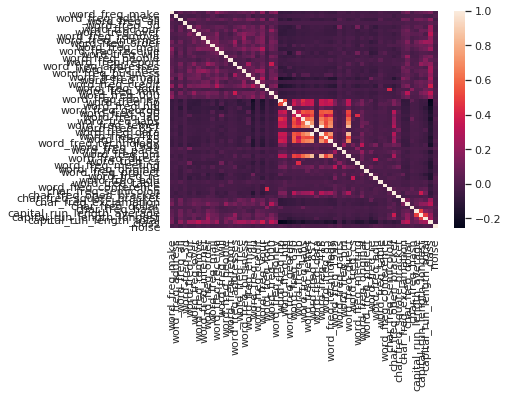

In [52]:
# Plot correlation matrix for numerical variables
# We can see [call] duration seems to have an impact on whether a loan is taken - this feels reasonable
corr = dataframe.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [53]:
# Split data (note this randomises the split so no stratification issues)
train_df, test_df = train_test_split(dataframe, test_size=0.2)
train_df.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_open_bracket,char_freq_square_bracket,char_freq_exclamation,char_freq_dollar,char_freq_hash,capital_run_length_average,capital_run_length_longest,capital_run_length_total,class,noise
1957,0.0,0.00,0.48,0.0,0.00,0.00,0.0,0.00,0.0,0.0,...,0.000,0.0,0.000,0.000,0.0,1.353,7,88,0,4
3722,0.0,0.33,0.00,0.0,0.33,0.00,0.0,0.00,0.0,0.0,...,0.132,0.0,0.000,0.000,0.0,1.857,15,117,0,2
452,0.0,0.48,0.48,0.0,0.48,0.00,0.0,0.48,0.0,0.0,...,0.084,0.0,0.084,0.336,0.0,3.200,12,80,1,0
3063,0.0,0.00,0.00,0.0,0.00,0.37,0.0,0.00,0.0,0.0,...,0.387,0.0,0.000,0.331,0.0,2.287,14,167,0,2
2778,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,...,0.000,0.0,0.000,0.000,0.0,1.333,3,8,0,2


In [54]:
batch_size = 100
train_ds = convert_df_dataset(train_df, 'class', batch_size=batch_size)
test_ds = convert_df_dataset(test_df, 'class', shuffle=False, batch_size=batch_size)

In [55]:
# Reset our feature columns
feature_columns = []

In [56]:
# Normalize and add numeric columns
# From: https://towardsdatascience.com/how-to-normalize-features-in-tensorflow-5b7b0e3a4177

# Get list of numeric columns
numeric_features_to_use = get_feature_names_of_type('numerical', metadata)

# Calculate mean and standard deviation (to feed into normalisation)
normalization_parameters = get_normalization_parameters(train_df, numeric_features_to_use)

# Get feature columns with built-in normaliser; add to list main list of columns
numeric_feature_columns = create_numeric_columns(train_df, numeric_features_to_use, normalization_parameters)
feature_columns += numeric_feature_columns

In [57]:
# Sanity check of feature columns - should be 57 for Spambase (note no categorical features)
print(len(feature_columns))

57


In [58]:
# Use our feature columns to create an input layer (i.e. a mapping from the tf.data file)
input_layer = tf.keras.layers.DenseFeatures(feature_columns)
input_layer

In [59]:
# Create our model
model = tf.keras.Sequential([
  input_layer,
  layers.Dense(256, activation='relu'),
  layers.Dropout(.2),
  layers.Dense(128, activation='relu'),
  layers.Dropout(.2),
  layers.Dense(128, activation='relu'),
  layers.Dropout(.2),
  layers.Dense(1, activation='sigmoid')
])


In [60]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]


In [61]:
# Compile and train our model
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=METRICS)



In [62]:
example_model, example_history = create_fit_model(train_ds, input_layer, METRICS, epochs=15, verbose=1)

Epoch 1/15
37/37 [==============================] - 2s 11ms/step - loss: 0.5552 - accuracy: 0.7252 - precision: 0.7558 - recall: 0.4706 - auc: 0.7655
Epoch 2/15
37/37 [==============================] - 0s 11ms/step - loss: 0.2490 - accuracy: 0.9148 - precision: 0.9154 - recall: 0.8680 - auc: 0.9616
Epoch 3/15
37/37 [==============================] - 0s 10ms/step - loss: 0.2227 - accuracy: 0.9198 - precision: 0.9098 - recall: 0.8896 - auc: 0.9674
Epoch 4/15
37/37 [==============================] - 0s 10ms/step - loss: 0.1921 - accuracy: 0.9277 - precision: 0.9223 - recall: 0.8951 - auc: 0.9760
Epoch 5/15
37/37 [==============================] - 1s 12ms/step - loss: 0.1768 - accuracy: 0.9367 - precision: 0.9354 - recall: 0.9073 - auc: 0.9797
Epoch 6/15
37/37 [==============================] - 0s 9ms/step - loss: 0.1632 - accuracy: 0.9434 - precision: 0.9414 - recall: 0.9128 - auc: 0.9824
Epoch 7/15
37/37 [==============================] - 0s 11ms/step - loss: 0.1567 - accuracy: 0.9433 - 

In [63]:
# Evaluate the overall accuracy of our model using the test set
loss, accuracy, precision, recall, auc = model.evaluate(test_ds)
print("Test set accuracy", accuracy)

# Calculate percentage of y=0 values for comparison
y_zero = test_df['class'].value_counts()[0]
y_one = test_df['class'].value_counts()[1]
print(y_zero / (y_zero + y_one))

10/10 [==============================] - 2s 14ms/step - loss: 0.6803 - accuracy: 0.9079 - precision: 0.8489 - recall: 0.9363 - auc: 0.9773
Test set accuracy 0.8793740272521973
0.6199782844733985


In [64]:
# Select an index value to predict/explain
index_to_explain = 200

In [65]:
# Allows us to predict a value for a specific instance
def predict_wrapper(model, instance, feature_names):
    input_tensor = convert_numpy_tensor(instance, feature_names)
    return model.predict(input_tensor)

feature_names = get_feature_names(metadata)
instance = convert_dataframe_numpy(dataframe, index_to_explain)
predict_wrapper(example_model, instance, feature_names)

array([[0.9999989]], dtype=float32)

In [66]:
# Set optimal constants for SHAP explanations
NUM_REFERENCE_VALUES = 50
NUM_PERTURBATIONS = 500

def shap_predictor_factory(feature_names, model):
    def predictor(instance):
        input_tensor = convert_numpy_tensor(instance, feature_names)
        return model.predict(input_tensor)
    return predictor

def get_explainer(predict_wrapper, dataframe_local, num_reference_values=50):
    # This never takes significant time - just calculating background values
    return shap.KernelExplainer(predict_wrapper, dataframe_local.iloc[:num_reference_values,:])

def generate_explanation(explainer, dataframe_local, index_to_explain, model_local, num_perturbations=500, chart=False, feature_names=[]):
    # Running time is O(num_reference_values * num_perturbations)
    global _shap_model
    _shap_model = model_local
    shap_values = explainer.shap_values(dataframe_local.iloc[index_to_explain,:], nsamples=num_perturbations)
    if chart == True:
        shap.summary_plot(np.array(shap_values), feature_names=feature_names, plot_type="bar")
    return shap_values

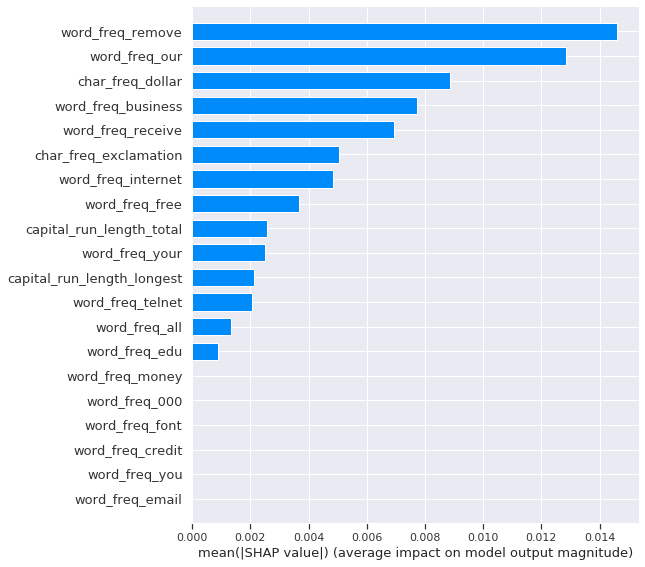

[array([ 0.        ,  0.        ,  0.00134595,  0.        ,  0.0128315 ,
        0.        ,  0.01461052, -0.00483525,  0.        ,  0.        ,
       -0.00692789,  0.        ,  0.        ,  0.        ,  0.        ,
        0.00367015,  0.00773554,  0.        ,  0.        ,  0.        ,
        0.00248527,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.00206159,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.00086993,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.00505497,  0.00884251,  0.        ,  0.        ,
        0.00210819,  0.00257896,  0.        ,  0.        ])]


In [67]:
shap_predictor = shap_predictor_factory(feature_names, example_model)
example_explainer = get_explainer(shap_predictor, dataframe)
example_shap_values = generate_explanation(example_explainer, dataframe, index_to_explain, example_model, chart=True, feature_names=feature_names)
print(example_shap_values)

In [68]:
instance_for_metrics = convert_dataframe_numpy(dataframe, index_to_explain)[0]

In [69]:
# Our external sensitivity metric shouldn't have to know about implementation of the explanation
def simple_explainer_factory(explainer, num_perturbations=NUM_PERTURBATIONS):
    def explainer_simple(this_instance):
        return explainer.shap_values(this_instance, nsamples=num_perturbations)[0]
    return explainer_simple

# Our fidelity function expects a model with a predict() attribute that just takes an array of numbers
def fidelity_model_factory(model, feature_names):
    class fidelity_model():
        def predict(instance):
            return predict_wrapper(model, [instance], feature_names)
    return fidelity_model

In [70]:

example_explainer_simple = simple_explainer_factory(example_explainer)

sensitivity = calculate_sensitivity(example_explainer_simple, example_shap_values, instance_for_metrics, metadata)
sensitivity

Perturbing  6 features
Finished perturbing feature #: 0 / 6
Finished perturbing feature #: 1 / 6
Finished perturbing feature #: 2 / 6
Finished perturbing feature #: 3 / 6
Finished perturbing feature #: 4 / 6
Finished perturbing feature #: 5 / 6


0.012841141058695674